<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/smc_logreg_tempering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SMC for logistic regression

We compare data tempering (IBIS) with temperature tempering.

Code is from 

https://github.com/nchopin/particles/blob/master/book/smc_samplers/logistic_reg.py




In [1]:
!git clone https://github.com/nchopin/particles.git

Cloning into 'particles'...
remote: Enumerating objects: 1506, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (416/416), done.
remote: Total 1506 (delta 445), reused 472 (delta 257), pack-reused 816
Receiving objects: 100% (1506/1506), 4.48 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (968/968), done.


In [2]:
%cd /content/particles

/content/particles


In [3]:
!pip install --user .

Processing /content/particles
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 28.5 MB 106 kB/s 
  Created wheel for particles: filename=particles-0.2-py3-none-any.whl size=573163 sha256=8c1ba4a552ad649ea25b8b27167304323c3b05bd28dd4b6844e5c252f8042588
  Stored in directory: /tmp/pip-ephem-wheel-cache-klz7twnq/wheels/c4/ec/4d/9651be18bff1d8c3beaff376421029d3d43569a79306f8a862
Successfully built particles
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires 

In [4]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists

In [7]:
"""
Numerical experiment of Chapter 17 (SMC samplers).
Compare IBIS and SMC tempering for approximating:
* the normalising constant (marginal likelihood)
* the posterior expectation of the p coefficients
for a logistic regression model.
See below for how to select the data-set.
Note: the SMC samplers implemented in module smc_samplers are now "waste-free"
by default, see Dau & Chopin (2021), and the documentation of `smc_samplers`
(plus the corresponding jupyter notebook). This script still performs exactly
the same numerical experiments as in the book, based on standard (non
waste-free) SMC samplers. To do so, we added ``wastefree=False`` to the
definition of the corresponding `Feynman-Kac` object. Again, see the
documentation of `smc_samplers` for more details.
"""

from matplotlib import pyplot as plt
import numpy as np
from numpy import random
import seaborn as sb

import particles
from particles import datasets as dts
from particles import distributions as dists
from particles import resampling as rs
from particles import smc_samplers as ssps
from particles.collectors import Moments

datasets = {"pima": dts.Pima, "eeg": dts.Eeg, "sonar": dts.Sonar}
dataset_name = "eeg"  # choose one of the three
data = datasets[dataset_name]().data
T, p = data.shape

# for each dataset, we adapt:
# * N: number of particles
# * Ks = list of Ks (nr MCMC steps)
# * typK: value of M used for plots on "typical" run

if dataset_name == "sonar":
    N = 10**4
    Ks = [10, 20, 30, 40, 50, 60]
    typK = 50
elif dataset_name == "pima":
    N = 10**3
    Ks = [1, 3, 5]
    typK = 3
elif dataset_name == "eeg":
    N = 10**3
    # Ks = [1, 3, 5, 7, 10, 15, 20]
    Ks = [1, 3, 5]
    typK = 5

# prior & model
prior = dists.StructDist({"beta": dists.MvNormal(scale=5.0, cov=np.eye(p))})


class LogisticRegression(ssps.StaticModel):
    def logpyt(self, theta, t):
        # log-likelihood factor t, for given theta
        lin = np.matmul(theta["beta"], data[t, :])
        return -np.logaddexp(0.0, -lin)

In [8]:
# algorithms
# N and values of K set above according to dataset
ESSrmin = 0.5
nruns = 2  # 16
results = []

# runs
print("Dataset: %s" % dataset_name)
for K in Ks:
    for i in range(nruns):
        # need to shuffle the data for IBIS
        random.shuffle(data)
        model = LogisticRegression(data=data, prior=prior)
        for alg_type in ["tempering", "ibis"]:
            if alg_type == "ibis":
                fk = ssps.IBIS(model=model, wastefree=False, len_chain=K + 1)
                pf = particles.SMC(N=N, fk=fk, ESSrmin=ESSrmin, collect=[Moments], verbose=False)
            else:
                fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, wastefree=False, len_chain=K + 1)
                pf = particles.SMC(N=N, fk=fk, ESSrmin=1.0, collect=[Moments], verbose=True)
                # must resample at every time step when doing adaptive
                # tempering
            print("%s, K=%i, run %i" % (alg_type, K, i))
            pf.run()
            print("CPU time (min): %.2f" % (pf.cpu_time / 60))
            print("loglik: %f" % pf.logLt)
            res = {"K": K, "type": alg_type, "out": pf.summaries, "cpu": pf.cpu_time}
            if alg_type == "ibis":
                n_eval = N * (T + K * sum([t for t in range(T) if pf.summaries.rs_flags[t]]))
            else:
                n_eval = N * T * (1.0 + K * (len(pf.summaries.ESSs) - 1))
                res["path_sampling"] = pf.X.shared["path_sampling"][-1]
                res["exponents"] = pf.X.shared["exponents"]
            res["n_eval"] = n_eval
            results.append(res)

Dataset: eeg
tempering, K=1, run 0
t=0, ESS=500.00, tempering exponent=9.31e-05
t=1, Metropolis acc. rate (over 1 steps): 0.257, ESS=500.00, tempering exponent=0.00029
t=2, Metropolis acc. rate (over 1 steps): 0.275, ESS=500.00, tempering exponent=0.000662
t=3, Metropolis acc. rate (over 1 steps): 0.265, ESS=500.00, tempering exponent=0.00142
t=4, Metropolis acc. rate (over 1 steps): 0.298, ESS=500.00, tempering exponent=0.00251
t=5, Metropolis acc. rate (over 1 steps): 0.304, ESS=500.00, tempering exponent=0.00385
t=6, Metropolis acc. rate (over 1 steps): 0.323, ESS=500.00, tempering exponent=0.00571
t=7, Metropolis acc. rate (over 1 steps): 0.320, ESS=500.00, tempering exponent=0.0086
t=8, Metropolis acc. rate (over 1 steps): 0.353, ESS=500.00, tempering exponent=0.0139
t=9, Metropolis acc. rate (over 1 steps): 0.337, ESS=500.00, tempering exponent=0.0222
t=10, Metropolis acc. rate (over 1 steps): 0.318, ESS=500.00, tempering exponent=0.0332
t=11, Metropolis acc. rate (over 1 steps):

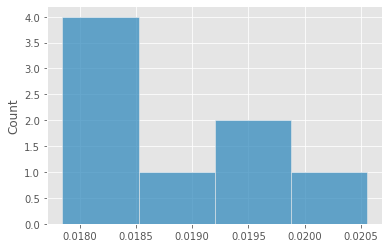

In [9]:
# plots
#######
savefigs = True  # do you want to save figures as pdfs
plt.style.use("ggplot")
pal = sb.dark_palette("white", n_colors=2)

# Compare standard and path sampling estimates of the log-normalising cst
plt.figure()
diff_est = [(r["out"].logLts[-1] - r["path_sampling"]) for r in results if r["type"] == "tempering"]
sb.histplot(diff_est)

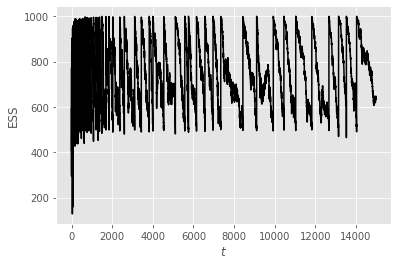

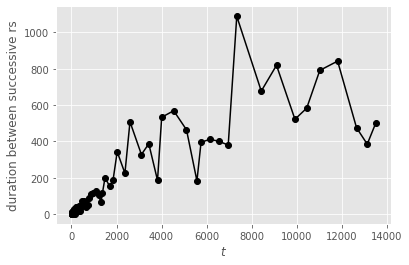

In [11]:
# Figure 17.1: typical behaviour of IBIS
typ_ibis = [r for r in results if r["type"] == "ibis" and r["K"] == typK][0]
typ_ess = typ_ibis["out"].ESSs
typ_rs_times = np.nonzero(typ_ibis["out"].rs_flags)[0]

# Left panel: evolution of ESS
fig, ax = plt.subplots()
ax.plot(typ_ess, "k")
ax.set(xlabel=r"$t$", ylabel="ESS")
if savefigs:
    plt.savefig(dataset_name + "_typical_ibis_ess.pdf")
    plt.savefig(dataset_name + "_typical_ibis_ess.png")

# Right panel: evolution of resampling times
fig, ax = plt.subplots()
ax.plot(typ_rs_times[:-1], np.diff(typ_rs_times), "ko-")
ax.set(xlabel=r"$t$", ylabel="duration between successive rs")
if savefigs:
    plt.savefig(dataset_name + "_typical_ibis_rs_times.pdf")
    plt.savefig(dataset_name + "_typical_ibis_rs_times.png")

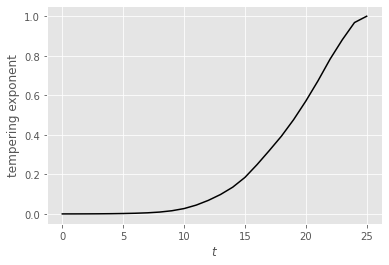

In [12]:
# Figure 17.2: evolution of temperature in a typical tempering run
typ_temp = [r for r in results if r["type"] == "tempering" and r["K"] == typK][0]
expnts = typ_temp["exponents"]
plt.figure()
plt.plot(expnts, "k")
plt.xlabel(r"$t$")
plt.ylabel("tempering exponent")
if savefigs:
    plt.savefig(dataset_name + "_typical_tempering_temperatures.pdf")
    plt.savefig(dataset_name + "_typical_tempering_temperatures.png")

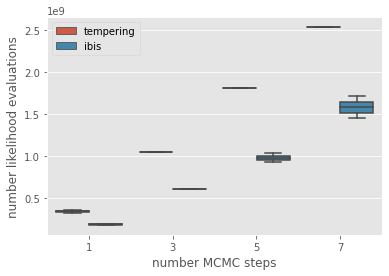

In [22]:
# nr evals vs K for both algorithms
plt.figure()
sb.boxplot(x=[r["K"] for r in results], y=[r["n_eval"] for r in results], hue=[r["type"] for r in results])
plt.xlabel("number MCMC steps")
plt.ylabel("number likelihood evaluations")
if savefigs:
    plt.savefig(dataset_name + "_boxplots_nevals_vs_K.pdf")
    plt.savefig(dataset_name + "_boxplots_nevals_vs_K.png")

In [20]:
print(type(results))
print(results[0])
for r in results:
    print(r["type"], "K=", r["K"], "time=", r["cpu"])

<class 'list'>
{'K': 1, 'type': 'tempering', 'out': <particles.collectors.Summaries object at 0x7f307c297a90>, 'cpu': 35.458105918, 'path_sampling': -9894.552441367015, 'exponents': [0.0, 9.306707012648636e-05, 0.0002898627563112856, 0.0006618455648883144, 0.0014183980691296664, 0.002507870437781154, 0.0038479550089156626, 0.005705163274481007, 0.008603119112205248, 0.013935392698910011, 0.022230662894991725, 0.033194739869915085, 0.051692383341063665, 0.08354491448844609, 0.12227938118802113, 0.17406891245698036, 0.23286324675513, 0.289010223871243, 0.35035677692909667, 0.443419593914814, 0.5712134103654529, 0.6994814843236252, 0.8324421117283232, 0.9946749866112512, 1.0], 'n_eval': 359520000.0}
tempering K= 1 time= 35.458105918
ibis K= 1 time= 27.205261016999998
tempering K= 1 time= 32.33377925000002
ibis K= 1 time= 28.813738553000007
tempering K= 3 time= 102.83632723400001
ibis K= 3 time= 73.07628615200008
tempering K= 3 time= 103.81470425999998
ibis K= 3 time= 70.56549695900003
tem

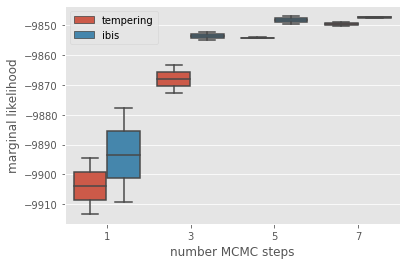

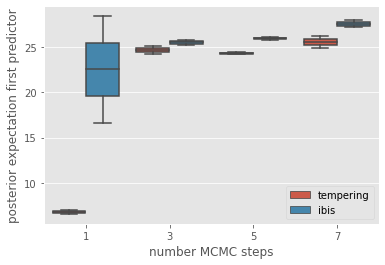

In [23]:
# Figure 17.3: Box-plots estimate versus number of MCMC steps
# Left panel: marginal likelihood
plt.figure()
sb.boxplot(x=[r["K"] for r in results], y=[r["out"].logLts[-1] for r in results], hue=[r["type"] for r in results])
plt.xlabel("number MCMC steps")
plt.ylabel("marginal likelihood")
if savefigs:
    plt.savefig(dataset_name + "_boxplots_marglik_vs_K.pdf")
    plt.savefig(dataset_name + "_boxplots_marglik_vs_K.png")

# Right panel: post expectation 1st pred
plt.figure()
sb.boxplot(
    x=[r["K"] for r in results],
    y=[r["out"].moments[-1]["mean"]["beta"][1] for r in results],
    hue=[r["type"] for r in results],
)
plt.xlabel("number MCMC steps")
plt.ylabel("posterior expectation first predictor")
if savefigs:
    plt.savefig(dataset_name + "_boxplots_postexp1_vs_K.pdf")
    plt.savefig(dataset_name + "_boxplots_postexp1_vs_K.png")

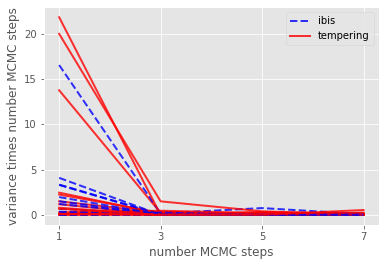

In [25]:
# Figure 17.4: variance vs CPU trade-off
# variance times K, as a function of K
plt.figure()
# cols = {'ibis': 'gray', 'tempering':'black'}
cols = {"ibis": "blue", "tempering": "red"}
lsts = {"ibis": "--", "tempering": "-"}
for i in range(p):
    for alg_type in ["ibis", "tempering"]:
        adj_var = []
        for K in Ks:
            mts = [r["out"].moments[-1] for r in results if r["K"] == K and r["type"] == alg_type]
            av = K * np.var([m["mean"]["beta"][i] for m in mts]) / np.mean([m["var"]["beta"][i] for m in mts])
            adj_var.append(av)
        if i == 0:
            plt.plot(
                Ks, adj_var, color=cols[alg_type], label=alg_type, alpha=0.8, linewidth=2, linestyle=lsts[alg_type]
            )
        else:
            plt.plot(Ks, adj_var, color=cols[alg_type], alpha=0.8, linewidth=2, linestyle=lsts[alg_type])
plt.legend()
plt.xticks(Ks, ["%i" % K for K in Ks])  # force int ticks
plt.xlabel("number MCMC steps")
plt.ylabel(r"variance times number MCMC steps")
if savefigs:
    plt.savefig(dataset_name + "_postexp_var_vs_K.pdf")
    plt.savefig(dataset_name + "_postexp_var_vs_K.png")

In [27]:
!ls *.png

eeg_boxplots_marglik_vs_K.png	eeg_typical_ibis_ess.png
eeg_boxplots_nevals_vs_K.png	eeg_typical_ibis_rs_times.png
eeg_boxplots_postexp1_vs_K.png	eeg_typical_tempering_temperatures.png
eeg_postexp_var_vs_K.png


In [28]:
!mkdir figures
!mv *.png figures
!mv *.pdf figures
!ls

book	     CONTRIBUTING.md  INSTALL  particles	 setup.py
CHANGELOG    docs	      LICENSE  README.md
_config.yml  figures	      papers   requirements.txt


In [30]:
!zip -r figures figures

  adding: figures/ (stored 0%)
  adding: figures/eeg_postexp_var_vs_K.pdf (deflated 30%)
  adding: figures/eeg_boxplots_marglik_vs_K.pdf (deflated 29%)
  adding: figures/eeg_boxplots_postexp1_vs_K.pdf (deflated 29%)
  adding: figures/eeg_postexp_var_vs_K.png (deflated 3%)
  adding: figures/eeg_typical_ibis_ess.pdf (deflated 6%)
  adding: figures/eeg_typical_ibis_ess.png (deflated 6%)
  adding: figures/eeg_typical_tempering_temperatures.pdf (deflated 41%)
  adding: figures/eeg_boxplots_postexp1_vs_K.png (deflated 10%)
  adding: figures/eeg_typical_ibis_rs_times.png (deflated 7%)
  adding: figures/eeg_typical_ibis_rs_times.pdf (deflated 35%)
  adding: figures/eeg_boxplots_marglik_vs_K.png (deflated 11%)
  adding: figures/eeg_boxplots_nevals_vs_K.pdf (deflated 30%)
  adding: figures/eeg_boxplots_nevals_vs_K.png (deflated 8%)
  adding: figures/eeg_typical_tempering_temperatures.png (deflated 10%)
